# Probit Maximum Likelihood

In this homework you should implement the maximum likelihood estimator for the probit model. To remind you, this model is defined as follows:
    $$
    \begin{align}  
    y_i  &\in \{0,1\} \\
    \Pr\{y_i=1\} &= \Phi(x_i \beta) \\
    L(\beta)   & = \Pi_{i=1}^N  \Phi(x_i \beta)^{y_i} (1-\Phi(x_i \beta))^{1-y_i} \\
    \beta  & \in \mathbb{R}^k \\
    x_i  & \sim N\left([0,0,0],\left[ \begin{array}{ccc} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{array} \right] \right) \\
    k & = 3 
    \end{align}
    $$
    
Where $\Phi$ is the standard Normal cdf. Think of $x_i$ as a row-vector. You should proceed as follows:

1. define a data generating function with default argument `N=10000`, generating `N` simulated data points from this model. Generate the data using $\beta=[1,1.5,-0.5]$. The function should return a `Dict` as outlined in the code.
1. Define the log likelihood function, $l(\beta) = \log(L)$
1. Write a function `plotLike` to plot the log likelihood function for different parameter values. Follow the outline of that function.
1. Define the function `maximize_like`. this should optimize your log likelihood function.
1. (Optional) Define the gradient of the log likelihood function and use it in another optimization `maximize_like_grad`.
1. (Optional) Define the hessian of the log likelihood function and use it in another optimization `maximize_like_grad_hess`.
1. (Optional) Use the hessian of the log likelihood function to compute the standard errors of your estimates and use it in `maximize_like_grad_se`

## Tests

* The code comes with a test suite that you should fill out. 
* There are some example tests, you should make those work and maybe add other ones. 
* Please do not change anything in the file structure.

In [75]:
using Distributions, Optim, Plots, DataFrames
pyplot()

# data generating function
function makeData(n=10000::Int, beta = [ 1; 1.5; -0.5 ]::Vector, k=3::Int)
    X = rand(MvNormal(eye(k)),n) # define X
    y = Array{Int}(n) #empty y
    for i in 1:n # define binomial y
        y[i] = rand(Bernoulli(cdf(Normal(),dot(X[:,i]',beta))))
    end
    # return a dict with beta,numobs,X,y,norm)
    return Dict("beta" => beta, "numobs" => n, "X" => X, "y" => y, "dist" => Normal())
    #return beta, X, y
end

makeData (generic function with 4 methods)

In [76]:
d = makeData()
d

Dict{String,Any} with 5 entries:
  "y"      => [0,0,0,0,1,0,1,1,0,0  …  1,1,1,1,1,1,1,1,1,0]
  "X"      => [1.1672 -0.558674 … -0.941077 -0.427729; -0.975839 0.16388 … -0.1…
  "numobs" => 10000
  "dist"   => Distributions.Normal{Float64}(μ=0.0, σ=1.0)
  "beta"   => [1.0,1.5,-0.5]

In [77]:
function loglik2(beta::Vector, d::Dict)
    l = sum(d["y"][i]*log(cdf(d["dist"],dot(d["X"][:,i]',beta)))+(1-d["y"][i])*log(1-cdf(d["dist"],dot(d["X"][:,i]',beta))) for i in 1:d["numobs"])
    return l
end
        
function loglik(beta::Vector,d::Dict)
    l = 0
    for i in 1:d["numobs"]
        if d["y"][i] == 1
            l = l + log(cdf(d["dist"],dot(d["X"][:,i]',beta)))
        else
            l = l + log(1-cdf(d["dist"],dot(d["X"][:,i]',beta)))
        #else
            #println("y[$i] was not a zero or a one.")
            #break
        end
    end
    return l
end
loglik(d["beta"], d), loglik2(d["beta"], d)
#d["y"][2] == 0

(-3382.9248235119467,-3382.9248235119467)

In [5]:
function plotLike()
    d = makeData()
    l1(x) = loglik([ x, d["beta"][2], d["beta"][3] ], d)
    l2(x) = loglik([ d["beta"][1], x, d["beta"][3] ], d)
    l3(x) = loglik([ d["beta"][1], d["beta"][2], x ], d)
    #x1 = linspace(0, 1, 100)
    plot1 = plot(linspace(0,2,100), l1, labels = "Varying beta[1]")
    plot2 = plot(linspace(.5,2.5,100), l2, labels = "Varying beta[2]")
    plot3 = plot(linspace(-1,0,100), l3, labels = "Varying beta[3]")
    return plot(plot1, plot2, plot3)
end

plotLike (generic function with 1 method)


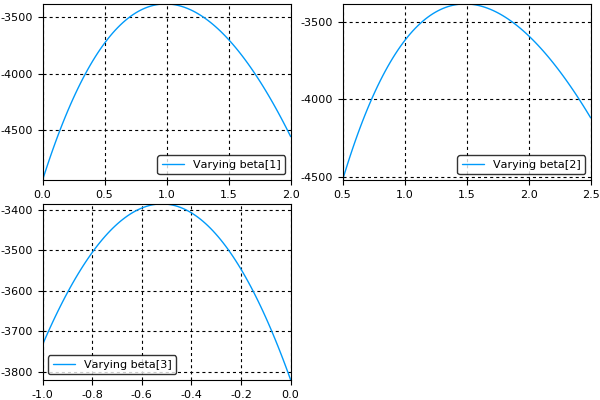

In [6]:
plotLike()

In [78]:
function maximize_like(x0=[0.8,1.0,-0.1],meth=NelderMead())
    d = makeData()
    l(beta) = -loglik(beta, d)
    res = optimize(l,x0)
    return res
end
maximize_like()

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.8,1.0,-0.1]
 * Minimizer: [1.0161299901983813,1.50473477104214, ...]
 * Minimum: 3.382647e+03
 * Iterations: 98
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 123

In [79]:
srand(12345)
d = makeData()
x0=[0.8,1.0,-0.1]
l(beta::Array) = loglik2(beta, d)
minl(beta) = -l(beta)
res = optimize(minl,x0, NelderMead())

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.8,1.0,-0.1]
 * Minimizer: [1.0071740273292469,1.5615720169752478, ...]
 * Minimum: 3.256289e+03
 * Iterations: 98
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 122

In [80]:
Optim.minimizer(res)

3-element Array{Float64,1}:
  1.00717 
  1.56157 
 -0.489881

In [54]:
l1(x) = loglik([ x, d["beta"][2], d["beta"][3] ], d)
l2(x) = loglik([ d["beta"][1], x, d["beta"][3] ], d)
l3(x) = loglik([ d["beta"][1], d["beta"][2], x ], d)

l3 (generic function with 1 method)

In [131]:
function grad!(beta::Vector, storage::Vector, d::Dict)
    g = zeros(length(beta))
    for i in 1:d["numobs"]
        if d["y"][i] == 1
            g = g + (pdf(d["dist"],dot(d["X"][:,i]',beta)))/(cdf(d["dist"],dot(d["X"][:,i]',beta)))*d["X"][:,i]
        else#if d["y"][i] == 0
            g = g - (pdf(d["dist"],dot(d["X"][:,i]',beta)))/(1-cdf(d["dist"],dot(d["X"][:,i]',beta)))*d["X"][:,i]
        #else
         #   println("y[$i] was not a zero or a one.")
          #  break
        end
    end
    storage[:] = -g
    #return g
end

grad! (generic function with 2 methods)

In [132]:
#(pdf(d["dist"],dot(d["X"][:,1]',[1,1.5,-.5])))/(cdf(d["dist"],dot(d["X"][:,1]',[1,1.5,-.5])))*d["X"][:,1]
grad!([1,1.5,-.5],zeros(3),d)

3-element Array{Float64,1}:
   41.3671
 -103.222 
  -68.1851

In [171]:
srand(1234)
function maximize_like_grad(x0=[0.8,1.0,-0.1],meth=BFGS())
    d = makeData()
    l(beta) = -(loglik(beta, d))
    g!(beta,storage) = grad!(beta,storage,d)
    res = optimize(l,g!,x0,meth)
    return res
end
maximize_like_grad().minimum

3397.6713952456994

In [129]:
l(beta) = -loglik(beta, d)
g!(beta,storage) = grad!(beta,storage,d)
res = optimize(l,g!,x0,BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.8,1.0,-0.1]
 * Minimizer: [0.8,1.0,-0.1]
 * Minimum: -3.634174e+03
 * Iterations: 1
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 75
 * Gradient Calls: 75

In [159]:
function hess!(beta::Vector{Float64},storage::Matrix{Float64}, d)
    h = zeros(size(storage)) 
    #Compute the Hessian 
    for i = 1:d["numobs"]
        XB = dot(d["X"][:,i]', beta) 
        phi = pdf(d["dist"], XB) 
        Phi = cdf(d["dist"], XB) 
        XXt = d["X"][:,i]*d["X"][:,i]'
        if d["y"][i] == 1
            h = h + phi * XXt * (phi + XB * Phi) / (Phi * Phi)
        else#if d["y"][i] == 0
            h = h + (phi - XB * (1 - Phi)) / ((1 - Phi) * (1 - Phi))
        #else
         #  println("y[$i] was not a zero or a one.")
          # break
        end
    end
    storage[:] = -h 
end

hess! (generic function with 1 method)

In [160]:
function maximize_like_grad_hess(x0=[0.8,1.0,-0.1],meth=Newton())
    d = makeData()
    l(beta) = -(loglik(beta, d))
    h!(beta,storage) = hess!(beta,storage,d)
    res = optimize(l,g!,h!,x0,meth)
    return res
end

maximize_like_grad_hess (generic function with 3 methods)

In [162]:
maximize_like_grad_hess()

Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.8,1.0,-0.1]
 * Minimizer: [0.9802339415321308,1.5261130791095625, ...]
 * Minimum: 3.433729e+03
 * Iterations: 9
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 90
 * Gradient Calls: 90

In [146]:
hess!([1,-1.5,-.5], zeros(3,3),d)

LoadError: DimensionMismatch("dimensions must match")

In [155]:
XXt = d["X"][:,1]*d["X"][:,1]'

3×3 Array{Float64,2}:
 1.37442   0.999678  0.487191
 0.999678  0.72711   0.354356
 0.487191  0.354356  0.172694

In [169]:
mean(d["X"][1,:])

-0.01538027403913557

In [168]:
d["X"]

3×10000 Array{Float64,2}:
 1.17236   0.516425  -1.47708   -0.158158  …  -1.26904   0.672225  -0.499428
 0.852707  0.685759   0.126747   0.606808      1.23262  -2.8509    -0.318974
 0.415565  0.282272   1.46647    2.00645      -1.72981  -0.318536   0.143369

In [183]:

#include("test/runtests.jl")

HW_unconstrained

In [ ]:
include("src/HW_unconstrained.jl")
HW_unconstrained.runAll()

In [176]:
function plotLike()
        d = makeData()
        l1(x) = loglik([ x, d["beta"][2], d["beta"][3] ], d)
        l2(x) = loglik([ d["beta"][1], x, d["beta"][3] ], d)
        l3(x) = loglik([ d["beta"][1], d["beta"][2], x ], d)
        #x1 = linspace(0, 1, 100)
        plot1 = plot(linspace(0,2,100), l1, labels = "Varying beta[1]")
        plot2 = plot(linspace(.5,2.5,100), l2, labels = "Varying beta[2]")
        plot3 = plot(linspace(-1,0,100), l3, labels = "Varying beta[3]")
        return plot(plot1, plot2, plot3)
    end

plotLike (generic function with 1 method)


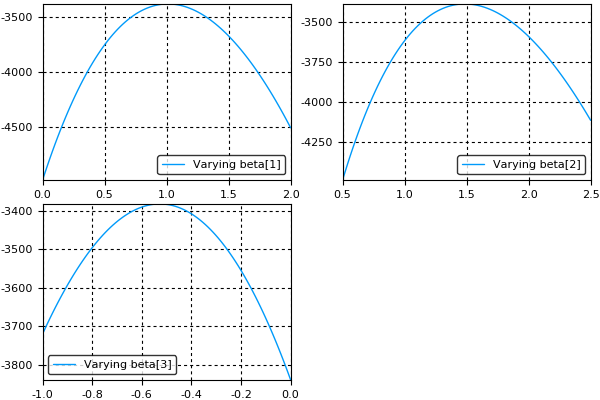

In [177]:
function plotLike()
        d = makeData()
        l1(x) = loglik([ x, d["beta"][2], d["beta"][3] ], d)
        l2(x) = loglik([ d["beta"][1], x, d["beta"][3] ], d)
        l3(x) = loglik([ d["beta"][1], d["beta"][2], x ], d)
        #x1 = linspace(0, 1, 100)
        plot1 = plot(linspace(0,2,100), l1, labels = "Varying beta[1]")
        plot2 = plot(linspace(.5,2.5,100), l2, labels = "Varying beta[2]")
        plot3 = plot(linspace(-1,0,100), l3, labels = "Varying beta[3]")
        return plot(plot1, plot2, plot3)
    end